In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
from unidecode import unidecode
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

In [432]:
from IPython.display import Javascript

Javascript('''
    IPython.notebook.trusted = true;
''')

<IPython.core.display.Javascript object>

In [372]:
# manzanas de Bogotá con ubicacion geografica y valor de m2
df_manzana = gpd.read_file("datasets/valor_m2_por_manzana1/Valor_ref_2023.shp")
# localidades de Bogotá con ubicacion geografica
df_localidades = gpd.read_file("datasets/localidades_bogota/poligonos-localidades.shp")
#Barrios legalizados y no legalizados de Bogotá con ubicacion geografica
df_barrios1 = gpd.read_file("datasets/barrios_bogota1/BarrioLegalizado.shp")
df_barrios2 = gpd.read_file("datasets/barrios_bogota2/barrios_prueba.shp")
#Densidad poblacional de Bogotá por UPZ
df_densidad = gpd.read_file("datasets/densidad_poblacional/poblacion-upz-bogota.shp")
#actividad economica por manzana de Bogotá
df_actividad_economica = gpd.read_file("datasets/actividad_economica/DestinoMZ.shp")


In [373]:
from shapely.geometry import Point
import json

with open("datasets/puntos_interes.geojson", "r", encoding="utf-8") as archivo:
    geojson_data = json.load(archivo)
rows = []
for feature in geojson_data["features"]:
    row = feature["properties"] 
    row["latitude"] = feature["geometry"]["coordinates"][1] 
    row["longitude"] = feature["geometry"]["coordinates"][0]
    rows.append(row)

df_interest_point = pd.DataFrame(rows)
interest_point_cat_weight = {
    "AMBI": 0.8, "COM-IND-TURI": 0.4, "CULT": 0.5, "DEP-REC": 0.8, "EDUC": 0.7, "FUN-PUB": 0.6, "SALUD": 0.9, "SEG-JUS": 0.6, "TRANS": 0.7, "UNADM": 0.6
}
df_interest_point["peso"] = df_interest_point["NGeClasifi"].map(interest_point_cat_weight).fillna(0)
ply_coord = [Point(x, y) for x, y in zip(df_interest_point["longitude"], df_interest_point["latitude"])]
df_interest_point = gpd.GeoDataFrame(df_interest_point, geometry=ply_coord, crs="EPSG:4326")

#puntos de interes categorizados de Bogotá, ejamplo: hospitales colegios etc
df_interest_point

NGeIdentif NGeEstado    NGeClasifi  \
0       17020001   Oficial  COM-IND-TURI   
1       17020002   Oficial  COM-IND-TURI   
2       17020003   Oficial  COM-IND-TURI   
3       17020004   Oficial  COM-IND-TURI   
4       17020005   Oficial  COM-IND-TURI   
...          ...       ...           ...   
14613   17052919   Oficial          EDUC   
14614   17052920   Oficial          EDUC   
14615   17052921   Oficial          EDUC   
14616   17052922   Oficial          EDUC   
14617   17031169   Oficial          CULT   

                                         NGeNombre NGeCPostal  NGeEscMax  \
0       Pasaje Cultural y Comercial CED Centenario     111511        100   
1      Caseta Feria Popular Rotonda Barrios Unidos     111211        100   
2                  Punto Comercial Siete de agosto     111221        100   
3                     Plataforma Logística de Bosa     110721        100   
4                       Centro Naturista El Abuelo     111711        100   
...                                            ...        ...        ...   
14613               Liceo Bilingüe Rómulo Gallegos     110741        100   
14614                     Colegio Superior Palermo     110741        100   
14615                       Liceo San Pablo Sede B     110741        100   
14616              Colegio Parques de Bogota (IED)     110721        100   
14617         Puente Diego Felipe Becerra Lizarazo     111121        100   

       NGeEscMin                                          NGeFuente  \
0           1500                   Camara de Comercio de Bogotá CCB   
1           1500                   Camara de Comercio de Bogotá CCB   
2           1500                   Camara de Comercio de Bogotá CCB   
3           1500                   Camara de Comercio de Bogotá CCB   
4           1500                   Camara de Comercio de Bogotá CCB   
...          ...                                                ...   
14613       1500              Secretaria Distrital de Educación SDE   
14614       1500              Secretaria Distrital de Educación SDE   
14615       1500              Secretaria Distrital de Educación SDE   
14616       1500              Secretaria Distrital de Educación SDE   
14617       5000  Acuerdo 907 de 2023 Concejo de Bogotá, D.C/Art...   

      NGeNAltern    NGeIdObRel  latitude  longitude  peso  \
0           None          None  4.584759 -74.104412   0.4   
1           None          None  4.677652 -74.085597   0.4   
2           None          None  4.658330 -74.071018   0.4   
3           None          None  4.632081 -74.199129   0.4   
4           None          None  4.600826 -74.077021   0.4   
...          ...           ...       ...        ...   ...   
14613       None  311001800740  4.602008 -74.156532   0.7   
14614       None  311001800103  4.605980 -74.194516   0.7   
14615       None  311102001066  4.604088 -74.187086   0.7   
14616       None  111001800678  4.625149 -74.192295   0.7   
14617       None          None  4.701148 -74.081454   0.5   

                        geometry  
0      POINT (-74.10441 4.58476)  
1       POINT (-74.0856 4.67765)  
2      POINT (-74.07102 4.65833)  
3      POINT (-74.19913 4.63208)  
4      POINT (-74.07702 4.60083)  
...                          ...  
14613  POINT (-74.15653 4.60201)  
14614  POINT (-74.19452 4.60598)  
14615  POINT (-74.18709 4.60409)  
14616  POINT (-74.19229 4.62515)  
14617  POINT (-74.08145 4.70115)  

[14618 rows x 14 columns]

In [374]:
def normalize_colums(df):
    df.columns = df.columns.str.lower()
    return df

In [375]:
#Se normaliza el nombre de las columnas
df_manzana = normalize_colums(df_manzana)
df_localidades = normalize_colums(df_localidades)
df_barrios1 = normalize_colums(df_barrios1)
df_barrios2 = normalize_colums(df_barrios2)
df_densidad = normalize_colums(df_densidad)
df_actividad_economica = normalize_colums(df_actividad_economica)
df_interest_point = normalize_colums(df_interest_point)

## Limpieza de datos

In [376]:
df_barrios1.rename(columns={"nombre": "barrio_name"}, inplace=True)
df_barrios2.rename(columns={"barriocomu": "barrio_name"}, inplace=True)

In [377]:
df_localidades["identificad"] = df_localidades["identificad"].astype(int)

In [378]:
df_manzana["v_ref_norm"] = df_manzana["v_ref"]/1000000

In [379]:
df_actividad_economica.rename(columns={"destinodes":"econom_type"}, inplace=True)
df_actividad_economica["econom_type"] = df_actividad_economica["econom_type"].astype(int)

In [380]:
#se determinan las columnas que se van a utilizar
columns_df_manzana = ['geometry', 'v_ref_norm', 'objectid']
columns_df_localidades = ['geometry', 'identificad','nombre_de_l'] 
columns_df_barrios1=['geometry', 'barrio_name'] 
columns_df_barrios2=['geometry', 'barrio_name'] 
columns_df_densidad=['geometry', 'densidad_ur', 'identificad'] 
columns_df_actividad_economica=['geometry', 'econom_type'] 
columns_df_interest_point=['geometry', 'ngeclasifi'] 

In [381]:
# se hace el filtrado de los outliers
df_manzana = df_manzana[df_manzana['v_ref_norm'] >= 0.5]
Q1 = df_manzana['v_ref_norm'].quantile(0.1) 
Q3 = df_manzana['v_ref_norm'].quantile(0.95)  
IQR = Q3 - Q1  

# Definir los límites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar el DataFrame para eliminar outliers
df_manzana = df_manzana[(df_manzana['v_ref_norm'] >= limite_inferior) & (df_manzana['v_ref_norm'] <= limite_superior)]

In [382]:
#necesitamos combinar la tabla de valor del m2 de las manzanas con la de actividad economica de las manzanas
df_manzana1 = gpd.sjoin(df_actividad_economica[columns_df_actividad_economica], df_manzana[columns_df_manzana], how="left", predicate="intersects")

In [383]:
df_manzana1

geometry  econom_type  \
0      POLYGON ((-74.14071 4.5587, -74.14072 4.55866,...            1   
1      POLYGON ((-74.04479 4.73293, -74.0448 4.73293,...           21   
1      POLYGON ((-74.04479 4.73293, -74.0448 4.73293,...           21   
1      POLYGON ((-74.04479 4.73293, -74.0448 4.73293,...           21   
2      POLYGON ((-74.12918 4.60612, -74.12923 4.60604...            1   
...                                                  ...          ...   
42841  POLYGON ((-74.12746 4.60959, -74.12744 4.60954...            4   
42841  POLYGON ((-74.12746 4.60959, -74.12744 4.60954...            4   
42842  POLYGON ((-74.11206 4.61853, -74.11226 4.61817...            1   
42843  POLYGON ((-74.17473 4.59141, -74.17474 4.59141...            1   
42844  POLYGON ((-74.15455 4.67025, -74.15455 4.67025...            1   

       index_right  v_ref_norm  objectid  
0             62.0        0.57  480703.0  
1          23360.0        3.40  504001.0  
1             63.0        4.20  480704.0  
1          28701.0        2.90  509342.0  
2             32.0        2.65  480673.0  
...            ...         ...       ...  
42841      38529.0        2.80  519170.0  
42841      39926.0        2.80  520567.0  
42842      39927.0        2.80  520568.0  
42843      39928.0        2.25  520569.0  
42844       9005.0        1.54  489646.0  

[52092 rows x 5 columns]

In [384]:
#cambiamos el tipo y nombre de la columna del numero de localidad
df_densidad["cod_loc"] = df_densidad["cod_loc"].astype(int)
df_densidad.rename(columns={"cod_loc": "identificad"}, inplace=True)
df_densidad


identificad            nomb_loc cod_upz        nom_upz  area_urbana  \
0              2           CHAPINERO      90    PARDO RUBIO   285.199005   
1              3            SANTA FE      96        LOURDES   200.137127   
2              4       SAN CRISTOBAL      50      LA GLORIA   385.857759   
3              5                USME      61    CIUDAD USME   925.470477   
4              6          TUNJUELITO      42        VENECIA   659.377024   
..           ...                 ...     ...            ...          ...   
108           11                SUBA      19       EL PRADO   433.403358   
109           12      BARRIOS UNIDOS      98  LOS ALCAZARES   414.026998   
110           15      ANTONIO NARIÑO      35  CIUDAD JARDIN   133.239133   
111           18  RAFAEL URIBE URIBE      36       SAN JOSE   207.947107   
112           19      CIUDAD BOLIVAR      70      JERUSALEM   537.476344   

     poblacion_u  densidad_ur  \
0        37191.0   130.403681   
1        46301.0   231.346381   
2       102299.0   265.121013   
3        13496.0    14.582853   
4       144420.0   219.024920   
..           ...          ...   
108      89013.0   205.381427   
109      82086.0   198.262433   
110      30913.0   232.011416   
111      49050.0   235.877290   
112      98693.0   183.622965   

                                              geometry  
0    POLYGON ((-74.05816 4.6507, -74.05802 4.65087,...  
1    POLYGON ((-74.0601 4.60224, -74.05979 4.60211,...  
2    POLYGON ((-74.10639 4.56384, -74.10643 4.56389...  
3    POLYGON ((-74.10795 4.49444, -74.10809 4.49417...  
4    POLYGON ((-74.15226 4.59568, -74.15172 4.59547...  
..                                                 ...  
108  POLYGON ((-74.06126 4.74091, -74.05927 4.74028...  
109  POLYGON ((-74.06739 4.67393, -74.05854 4.67897...  
110  POLYGON ((-74.08905 4.59196, -74.08893 4.59192...  
111  POLYGON ((-74.10246 4.58124, -74.09894 4.57886...  
112  POLYGON ((-74.15736 4.58045, -74.15554 4.57693...  

[113 rows x 8 columns]

In [385]:
#vemos la densidad poblacional por localidad
df_densidad_group_localidad = df_densidad[columns_df_densidad].groupby("identificad").sum(numeric_only=True)
df_densidad_group_localidad

densidad_ur
identificad             
1            1204.093122
2             554.867104
3             770.042954
4            1255.271307
5             922.256497
6             395.340614
7            1139.700936
8            3112.664235
9             890.145797
10           1866.532832
11           1795.702034
12            686.159666
13            699.329772
14            340.660690
15            449.148804
16            749.216432
17            116.952210
18           1460.082738
19           1617.076530

<Axes: >

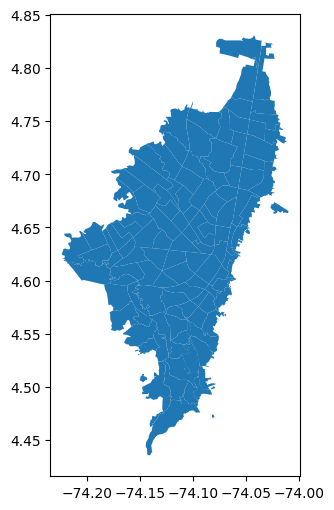

In [386]:
#grafica de las UPZ 
df_densidad.plot(figsize=(6, 6))

<Axes: >

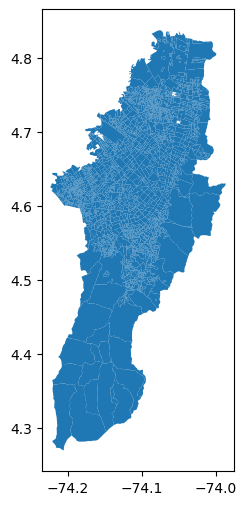

In [387]:
#grafica de barrios legalizados
df_barrios2.plot(figsize=(6, 6))

<Axes: >

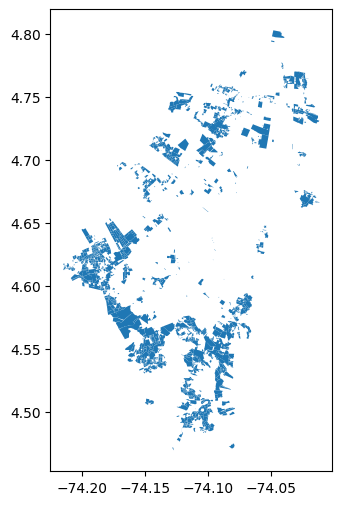

In [388]:
#grafica de barrios por legalizar
gdf = gpd.GeoDataFrame(geometry=df_barrios1["geometry"])
gdf_wgs84 = gdf.to_crs(epsg=4326)
df_barrios1["geometry"] = gdf_wgs84.geometry
df_barrios1.plot(figsize=(6, 6))

<Axes: >

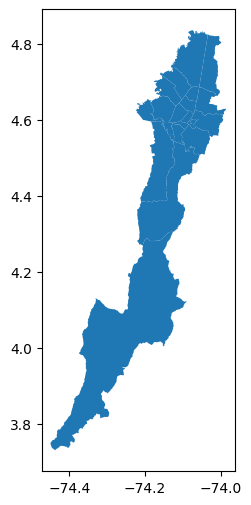

In [389]:
df_localidades.plot(figsize=(6, 6))

In [390]:

def remover_tildes(texto):
    return unidecode(texto)

In [391]:
#normalizamos en nombre de los barrios y concatemanos las dos tablas
df_barrios1.columns = df_barrios1.columns.str.lower()
df_barrios = pd.concat([df_barrios1[columns_df_barrios1], df_barrios2[columns_df_barrios2]], axis=0)
df_barrios["name_normalized"] = df_barrios["barrio_name"].str.strip().str.title().str.replace(r'\s+', ' ', regex=True)
df_barrios['name_normalized'] = df_barrios['name_normalized'].apply(remover_tildes)
df_barrios = df_barrios.drop_duplicates(subset=['name_normalized'], keep='first')

df_barrios


geometry  \
0     POLYGON ((-74.14116 4.53406, -74.14117 4.53403...   
1     POLYGON ((-74.15214 4.59591, -74.15212 4.59594...   
2     POLYGON ((-74.20224 4.62291, -74.20224 4.6229,...   
3     POLYGON ((-74.18936 4.60996, -74.18931 4.60955...   
4     MULTIPOLYGON (((-74.19803 4.60328, -74.19809 4...   
...                                                 ...   
3864  POLYGON ((-74.13772 4.5554, -74.13792 4.55508,...   
3865  POLYGON ((-74.17284 4.5864, -74.17276 4.58556,...   
3866  POLYGON ((-74.10063 4.54816, -74.10032 4.54777...   
3867  POLYGON ((-74.11975 4.48745, -74.11987 4.4874,...   
3868  POLYGON ((-74.1416 4.66705, -74.14195 4.66679,...   

                                  barrio_name  \
0                                  LOS DUQUES   
1                                   GUADALUPE   
2                                SAN JORGE II   
3               URBANIZACION PIAMONTE I ETAPA   
4     MIRAFLORES 2 SECTOR BARRIO CARLOS ALBAN   
...                                       ...   
3864                San Luís Altos de Jalisco   
3865           San Rafael Alto de la Estancia   
3866                  La Península El Paraíso   
3867               Vereda El Pedregal La Lira   
3868                                  Guadual   

                              name_normalized  
0                                  Los Duques  
1                                   Guadalupe  
2                                San Jorge Ii  
3               Urbanizacion Piamonte I Etapa  
4     Miraflores 2 Sector Barrio Carlos Alban  
...                                       ...  
3864                San Luis Altos De Jalisco  
3865           San Rafael Alto De La Estancia  
3866                  La Peninsula El Paraiso  
3867               Vereda El Pedregal La Lira  
3868                                  Guadual  

[4817 rows x 3 columns]

In [392]:
#unimos la tabla de localidades, con la de densidad poblacional por localidades
df_densidad_group_localidad = df_localidades[columns_df_localidades].merge(df_densidad_group_localidad, on='identificad', how='left')
df_densidad_group_localidad = df_densidad_group_localidad.dropna()
df_densidad_group_localidad

geometry  identificad  \
0   POLYGON ((-74.18135 4.58892, -74.18162 4.58944...           19   
1   POLYGON ((-74.0345 4.82547, -74.03478 4.82418,...           11   
2   POLYGON ((-74.12803 4.59254, -74.12777 4.59233...           18   
3   POLYGON ((-74.1183 4.63741, -74.11845 4.63727,...            8   
4   POLYGON ((-74.05597 4.50832, -74.05611 4.50822...            5   
5   POLYGON ((-74.07283 4.61542, -74.07311 4.6148,...           14   
6   POLYGON ((-74.13075 4.59335, -74.12917 4.59327...           15   
7   POLYGON ((-74.09372 4.66607, -74.09332 4.66574...           13   
9   POLYGON ((-74.029 4.5583, -74.0293 4.55821, -7...            4   
10  POLYGON ((-74.01089 4.66358, -74.0109 4.66366,...            1   
11  POLYGON ((-74.13777 4.59489, -74.13165 4.59363...            6   
12  POLYGON ((-74.18567 4.64705, -74.1848 4.64497,...            7   
13  POLYGON ((-74.1183 4.63741, -74.11504 4.64053,...           16   
14  POLYGON ((-73.99446 4.61425, -73.99446 4.61425...            3   
15  POLYGON ((-74.05725 4.68684, -74.06249 4.65594...           12   
16  POLYGON ((-74.10342 4.65351, -74.1075 4.64823,...            9   
17  POLYGON ((-74.15547 4.71798, -74.15547 4.71798...           10   
18  POLYGON ((-74.06621 4.60317, -74.0662 4.60317,...           17   
19  POLYGON ((-74.01089 4.66358, -74.01104 4.66359...            2   

           nombre_de_l  densidad_ur  
0       CIUDAD BOLIVAR  1617.076530  
1                 SUBA  1795.702034  
2   RAFAEL URIBE URIBE  1460.082738  
3              KENNEDY  3112.664235  
4                 USME   922.256497  
5         LOS MARTIRES   340.660690  
6       ANTONIO NARIÑO   449.148804  
7          TEUSAQUILLO   699.329772  
9        SAN CRISTOBAL  1255.271307  
10             USAQUEN  1204.093122  
11          TUNJUELITO   395.340614  
12                BOSA  1139.700936  
13       PUENTE ARANDA   749.216432  
14            SANTA FE   770.042954  
15      BARRIOS UNIDOS   686.159666  
16            FONTIBON   890.145797  
17            ENGATIVA  1866.532832  
18          CANDELARIA   116.952210  
19           CHAPINERO   554.867104

In [393]:
#unimos la tabla resultante con la de barrios
localidad_barrio = gpd.sjoin(df_barrios, df_densidad_group_localidad, how="left", predicate="intersects")
#hallamos el punto central de el poligono de la tabla de barrios resultante
localidad_barrio["lon_barr"] = localidad_barrio.geometry.centroid.x
localidad_barrio["lat_barr"] = localidad_barrio.geometry.centroid.y
localidad_barrio = localidad_barrio.dropna()

/tmp/ipykernel_16583/2158123962.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  localidad_barrio["lon_barr"] = localidad_barrio.geometry.centroid.x
/tmp/ipykernel_16583/2158123962.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  localidad_barrio["lat_barr"] = localidad_barrio.geometry.centroid.y


In [394]:
#ahora unimos la tabla resultante con la de manzanas 
localidad_barrio = localidad_barrio.drop(columns=["index_right"])
df_manzana1 = df_manzana1.drop(columns=["index_right"])
localidad_barrio_manzana = gpd.sjoin(df_manzana1, localidad_barrio, how="left", predicate="intersects")
localidad_barrio_manzana = localidad_barrio_manzana[~localidad_barrio_manzana["name_normalized"].isna()]
localidad_barrio_manzana = localidad_barrio_manzana.drop_duplicates("objectid")


In [395]:

localidad_barrio_manzana["lon"] = localidad_barrio_manzana.geometry.centroid.x
localidad_barrio_manzana["lat"] = localidad_barrio_manzana.geometry.centroid.y
localidad_barrio_manzana

/tmp/ipykernel_16583/636036730.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  localidad_barrio_manzana["lon"] = localidad_barrio_manzana.geometry.centroid.x
/tmp/ipykernel_16583/636036730.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  localidad_barrio_manzana["lat"] = localidad_barrio_manzana.geometry.centroid.y


geometry  econom_type  \
0      POLYGON ((-74.14071 4.5587, -74.14072 4.55866,...            1   
1      POLYGON ((-74.04479 4.73293, -74.0448 4.73293,...           21   
1      POLYGON ((-74.04479 4.73293, -74.0448 4.73293,...           21   
1      POLYGON ((-74.04479 4.73293, -74.0448 4.73293,...           21   
2      POLYGON ((-74.12918 4.60612, -74.12923 4.60604...            1   
...                                                  ...          ...   
42839  POLYGON ((-74.11157 4.61546, -74.11163 4.61543...            1   
42840  POLYGON ((-74.08109 4.62154, -74.08112 4.62152...           23   
42842  POLYGON ((-74.11206 4.61853, -74.11226 4.61817...            1   
42843  POLYGON ((-74.17473 4.59141, -74.17474 4.59141...            1   
42844  POLYGON ((-74.15455 4.67025, -74.15455 4.67025...            1   

       v_ref_norm  objectid  index_right                      barrio_name  \
0            0.57  480703.0       1352.0                 ALTOS DE JALISCO   
1            3.40  504001.0       3706.0                    Cedro Bolívar   
1            4.20  480704.0       3706.0                    Cedro Bolívar   
1            2.90  509342.0       3706.0                    Cedro Bolívar   
2            2.65  480673.0       1216.0                      Los_Ángeles   
...           ...       ...          ...                              ...   
42839        2.80  520565.0       2566.0             Primavera Occidental   
42840        3.20  520566.0       1198.0                   Samper Mendoza   
42842        2.80  520568.0        520.0  Primavera Norte - San Francisco   
42843        2.25  520569.0       3299.0                      La Estancia   
42844        1.54  489646.0       1056.0              Predio Cundinamarca   

                       name_normalized  identificad     nombre_de_l  \
0                     Altos De Jalisco         19.0  CIUDAD BOLIVAR   
1                        Cedro Bolivar          1.0         USAQUEN   
1                        Cedro Bolivar          1.0         USAQUEN   
1                        Cedro Bolivar          1.0         USAQUEN   
2                          Los_Angeles         16.0   PUENTE ARANDA   
...                                ...          ...             ...   
42839             Primavera Occidental         16.0   PUENTE ARANDA   
42840                   Samper Mendoza         14.0    LOS MARTIRES   
42842  Primavera Norte - San Francisco         16.0   PUENTE ARANDA   
42843                      La Estancia         19.0  CIUDAD BOLIVAR   
42844              Predio Cundinamarca          9.0        FONTIBON   

       densidad_ur   lon_barr  lat_barr        lon       lat  
0      1617.076530 -74.140402  4.557931 -74.140734  4.558974  
1      1204.093122 -74.046630  4.735419 -74.045062  4.733394  
1      1204.093122 -74.046630  4.735419 -74.045062  4.733394  
1      1204.093122 -74.046630  4.735419 -74.045062  4.733394  
2       749.216432 -74.129692  4.606528 -74.129645  4.606536  
...            ...        ...       ...        ...       ...  
42839   749.216432 -74.108830  4.615099 -74.111811  4.615558  
42840   340.660690 -74.081692  4.619199 -74.081129  4.622009  
42842   749.216432 -74.109494  4.620070 -74.112637  4.618293  
42843  1617.076530 -74.174385  4.594071 -74.174631  4.591624  
42844   890.145797 -74.153646  4.670559 -74.154725  4.670843  

[37385 rows x 14 columns]

In [396]:
#combinamos la tabla resultante con la de POI y creamos un conteo de POI para determinar las zonas con mas puntos de interes
localidad_barrio_manzana = localidad_barrio_manzana.drop(columns=["index_right"])
poi_barrios = gpd.sjoin(df_interest_point[columns_df_interest_point],localidad_barrio_manzana , how="left", predicate="intersects")
conteo_puntos_por_barrio = poi_barrios.groupby('index_right').size().reset_index(name='conteo_puntos')
localidad_barrio_manzana_poi = localidad_barrio_manzana.merge(conteo_puntos_por_barrio, left_index=True, right_on='index_right', how='left')
localidad_barrio_manzana_poi["conteo_puntos"].fillna(0, inplace=True)
localidad_barrio_manzana_poi

/tmp/ipykernel_16583/4135018412.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  localidad_barrio_manzana_poi["conteo_puntos"].fillna(0, inplace=True)


geometry  econom_type  \
NaN     POLYGON ((-74.14071 4.5587, -74.14072 4.55866,...            1   
0.0     POLYGON ((-74.04479 4.73293, -74.0448 4.73293,...           21   
0.0     POLYGON ((-74.04479 4.73293, -74.0448 4.73293,...           21   
0.0     POLYGON ((-74.04479 4.73293, -74.0448 4.73293,...           21   
1.0     POLYGON ((-74.12918 4.60612, -74.12923 4.60604...            1   
...                                                   ...          ...   
NaN     POLYGON ((-74.11157 4.61546, -74.11163 4.61543...            1   
6321.0  POLYGON ((-74.08109 4.62154, -74.08112 4.62152...           23   
NaN     POLYGON ((-74.11206 4.61853, -74.11226 4.61817...            1   
NaN     POLYGON ((-74.17473 4.59141, -74.17474 4.59141...            1   
6322.0  POLYGON ((-74.15455 4.67025, -74.15455 4.67025...            1   

        v_ref_norm  objectid                      barrio_name  \
NaN           0.57  480703.0                 ALTOS DE JALISCO   
0.0           3.40  504001.0                    Cedro Bolívar   
0.0           4.20  480704.0                    Cedro Bolívar   
0.0           2.90  509342.0                    Cedro Bolívar   
1.0           2.65  480673.0                      Los_Ángeles   
...            ...       ...                              ...   
NaN           2.80  520565.0             Primavera Occidental   
6321.0        3.20  520566.0                   Samper Mendoza   
NaN           2.80  520568.0  Primavera Norte - San Francisco   
NaN           2.25  520569.0                      La Estancia   
6322.0        1.54  489646.0              Predio Cundinamarca   

                        name_normalized  identificad     nombre_de_l  \
NaN                    Altos De Jalisco         19.0  CIUDAD BOLIVAR   
0.0                       Cedro Bolivar          1.0         USAQUEN   
0.0                       Cedro Bolivar          1.0         USAQUEN   
0.0                       Cedro Bolivar          1.0         USAQUEN   
1.0                         Los_Angeles         16.0   PUENTE ARANDA   
...                                 ...          ...             ...   
NaN                Primavera Occidental         16.0   PUENTE ARANDA   
6321.0                   Samper Mendoza         14.0    LOS MARTIRES   
NaN     Primavera Norte - San Francisco         16.0   PUENTE ARANDA   
NaN                         La Estancia         19.0  CIUDAD BOLIVAR   
6322.0              Predio Cundinamarca          9.0        FONTIBON   

        densidad_ur   lon_barr  lat_barr        lon       lat  index_right  \
NaN     1617.076530 -74.140402  4.557931 -74.140734  4.558974          0.0   
0.0     1204.093122 -74.046630  4.735419 -74.045062  4.733394          1.0   
0.0     1204.093122 -74.046630  4.735419 -74.045062  4.733394          1.0   
0.0     1204.093122 -74.046630  4.735419 -74.045062  4.733394          1.0   
1.0      749.216432 -74.129692  4.606528 -74.129645  4.606536          2.0   
...             ...        ...       ...        ...       ...          ...   
NaN      749.216432 -74.108830  4.615099 -74.111811  4.615558      42839.0   
6321.0   340.660690 -74.081692  4.619199 -74.081129  4.622009      42840.0   
NaN      749.216432 -74.109494  4.620070 -74.112637  4.618293      42842.0   
NaN     1617.076530 -74.174385  4.594071 -74.174631  4.591624      42843.0   
6322.0   890.145797 -74.153646  4.670559 -74.154725  4.670843      42844.0   

        conteo_puntos  
NaN               0.0  
0.0               3.0  
0.0               3.0  
0.0               3.0  
1.0               1.0  
...               ...  
NaN               0.0  
6321.0            2.0  
NaN               0.0  
NaN               0.0  
6322.0            1.0  

[37385 rows x 15 columns]

In [397]:
localidad_barrio_manzana_poi["lon_manz"] = localidad_barrio_manzana_poi.geometry.centroid.x
localidad_barrio_manzana_poi["lat_manz"] = localidad_barrio_manzana_poi.geometry.centroid.y

/tmp/ipykernel_16583/1514131439.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  localidad_barrio_manzana_poi["lon_manz"] = localidad_barrio_manzana_poi.geometry.centroid.x
/tmp/ipykernel_16583/1514131439.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  localidad_barrio_manzana_poi["lat_manz"] = localidad_barrio_manzana_poi.geometry.centroid.y


In [398]:
localidad_barrio_manzana_poi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 37385 entries, nan to 6322.0
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   geometry         37385 non-null  geometry
 1   econom_type      37385 non-null  int64   
 2   v_ref_norm       37384 non-null  float64 
 3   objectid         37384 non-null  float64 
 4   barrio_name      37385 non-null  object  
 5   name_normalized  37385 non-null  object  
 6   identificad      37385 non-null  float64 
 7   nombre_de_l      37385 non-null  object  
 8   densidad_ur      37385 non-null  float64 
 9   lon_barr         37385 non-null  float64 
 10  lat_barr         37385 non-null  float64 
 11  lon              37385 non-null  float64 
 12  lat              37385 non-null  float64 
 13  index_right      37385 non-null  float64 
 14  conteo_puntos    37385 non-null  float64 
 15  lon_manz         37385 non-null  float64 
 16  lat_manz         37385 non-null  f

In [399]:
localidad_barrio_manzana_poi.describe()

econom_type    v_ref_norm       objectid   identificad   densidad_ur  \
count  37385.000000  37384.000000   37384.000000  37385.000000  37385.000000   
mean      11.670456      2.199401  501599.586267      9.862512   1465.273793   
std       21.451904      1.156065   12189.846769      5.281877    747.343140   
min        1.000000      0.500000  480641.000000      1.000000    116.952210   
25%        1.000000      1.400000  490969.750000      6.000000    922.256497   
50%        1.000000      2.100000  501576.500000      9.000000   1255.271307   
75%        6.000000      2.800000  512164.250000     13.000000   1795.702034   
max       67.000000      8.700000  522736.000000     19.000000   3112.664235   

           lon_barr      lat_barr           lon           lat   index_right  \
count  37385.000000  37385.000000  37385.000000  37385.000000  37385.000000   
mean     -74.117304      4.630719    -74.117318      4.630907  20078.513441   
std        0.041335      0.069104      0.041293      0.069084  12377.111793   
min      -74.214228      4.469973    -74.215199      4.469417      0.000000   
25%      -74.147499      4.577866    -74.147438      4.577832   9205.000000   
50%      -74.114182      4.622056    -74.114156      4.621969  19390.000000   
75%      -74.090125      4.689817    -74.090171      4.690334  30611.000000   
max      -74.014681      4.818364    -74.019273      4.821173  42844.000000   

       conteo_puntos      lon_manz      lat_manz  
count   37385.000000  37385.000000  37385.000000  
mean        0.651384    -74.117318      4.630907  
std         7.146422      0.041293      0.069084  
min         0.000000    -74.215199      4.469417  
25%         0.000000    -74.147438      4.577832  
50%         0.000000    -74.114156      4.621969  
75%         0.000000    -74.090171      4.690334  
max       260.000000    -74.019273      4.821173

In [400]:
localidad_barrio_manzana_poi = localidad_barrio_manzana_poi.dropna()

In [401]:
localidad_barrio_manzana_poi = localidad_barrio_manzana_poi.drop(columns=["index_right"])
localidad_barrio_manzana_poi.reset_index(drop=True, inplace=True)

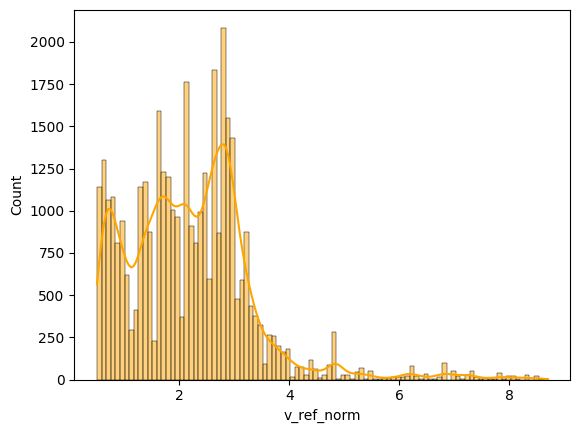

In [402]:
sns.histplot(data=localidad_barrio_manzana_poi, x="v_ref_norm", color="orange", alpha=0.5, kde=True)
plt.show()

In [403]:
gdf_barrios_group = localidad_barrio_manzana_poi[['nombre_de_l', "conteo_puntos"]].groupby("nombre_de_l").sum(numeric_only = True).sort_values("conteo_puntos")
gdf_barrios_group

conteo_puntos
nombre_de_l                      
ANTONIO NARIÑO              140.0
LOS MARTIRES                247.0
BARRIOS UNIDOS              354.0
TUNJUELITO                  380.0
TEUSAQUILLO                 500.0
SANTA FE                    539.0
PUENTE ARANDA               748.0
SAN CRISTOBAL               765.0
CHAPINERO                   826.0
FONTIBON                    831.0
RAFAEL URIBE URIBE          853.0
CANDELARIA                  982.0
CIUDAD BOLIVAR             1022.0
BOSA                       1100.0
USAQUEN                    1593.0
ENGATIVA                   1681.0
KENNEDY                    1766.0
SUBA                       2549.0
USME                       7475.0

In [404]:
mapa = folium.Map(location=[4.65, -74.1], zoom_start=12)

In [405]:
#concentraciuon de puntos de interes
heat_data = list(zip(localidad_barrio_manzana_poi["lat_barr"], localidad_barrio_manzana_poi["lon_barr"],localidad_barrio_manzana_poi["conteo_puntos"]))
HeatMap(heat_data, radius=10, blur=6, max_zoom=1).add_to(mapa)

mapa

In [406]:
barrio_group = localidad_barrio_manzana_poi[["name_normalized", "geometry", "densidad_ur", "lat", "lon"]].groupby("name_normalized").first()
barrio_group = barrio_group.dropna()

In [407]:
#densidad poblacional bogota

heat_data = list(zip(localidad_barrio["lat_barr"], localidad_barrio["lon_barr"],localidad_barrio["densidad_ur"]))
HeatMap(heat_data, radius=8, blur=3, max_zoom=1).add_to(mapa)

#mapa.save("heatmap.html")
mapa

In [408]:
# import folium
# from folium.plugins import MarkerCluster

# m = folium.Map(location=[4.65, -74.1], zoom_start=11)

# for _, r in localidad_barrio_manzana.iterrows():
#     #without simplifying the representation of each borough, the map might not be displayed
#     #sim_geo = gpd.GeoSeries(r['geometry'])
#     sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
#     geo_j = sim_geo.to_json()
#     geo_j = folium.GeoJson(data=geo_j,
#                            style_function=lambda x: {'fillColor': 'orange'})
#     folium.Popup(f"Valor: {r['Vr_Integra']:.2f}").add_to(geo_j)
#     geo_j.add_to(m)
# m

In [409]:
localidad_value_m2_avg = localidad_barrio_manzana[["nombre_de_l", "v_ref_norm", ]].groupby("nombre_de_l").mean()
localidad_value_m2_avg = localidad_value_m2_avg.sort_values("v_ref_norm")
localidad_value_m2_avg

v_ref_norm
nombre_de_l                   
USME                  0.973905
CIUDAD BOLIVAR        1.217602
SAN CRISTOBAL         1.281384
RAFAEL URIBE URIBE    1.687580
BOSA                  1.750312
SANTA FE              2.033683
TUNJUELITO            2.142793
KENNEDY               2.288849
SUBA                  2.320806
CANDELARIA            2.444439
FONTIBON              2.466810
ENGATIVA              2.649919
ANTONIO NARIÑO        2.701736
LOS MARTIRES          2.807167
PUENTE ARANDA         2.809810
BARRIOS UNIDOS        3.147382
TEUSAQUILLO           3.170610
USAQUEN               3.332717
CHAPINERO             4.827041

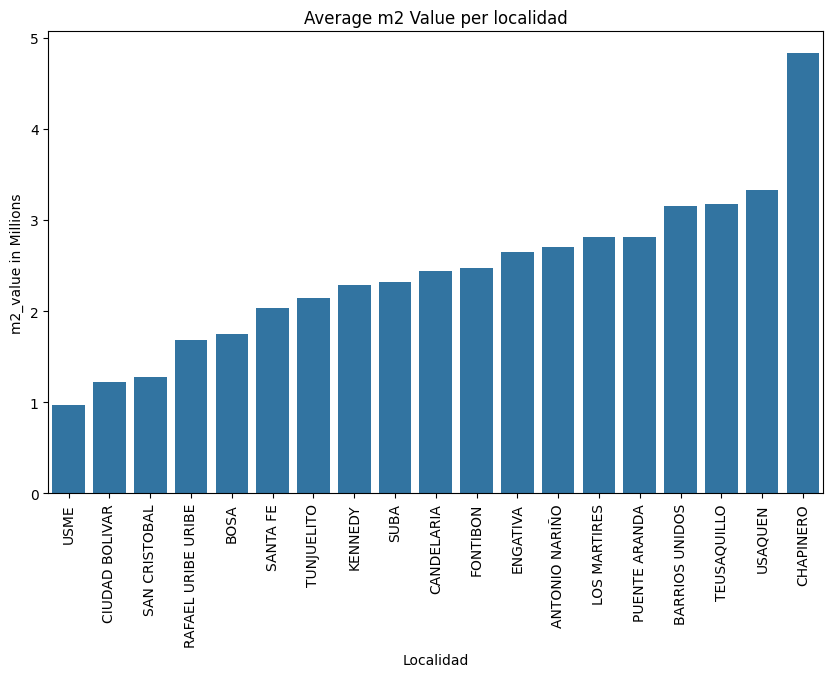

In [410]:
plt.figure(figsize=(10, 6))
sns.barplot(data=localidad_value_m2_avg, x='nombre_de_l', y="v_ref_norm")
plt.title('Average m2 Value per localidad')
plt.xlabel('Localidad')
plt.ylabel('m2_value in Millions')
plt.xticks(rotation=90)
plt.show()

In [411]:
# import folium
# from folium.plugins import MarkerCluster

# m = folium.Map(location=[4.65, -74.1], zoom_start=11)

# for _, r in paloq_barrio.iterrows():
#     #without simplifying the representation of each borough, the map might not be displayed
#     #sim_geo = gpd.GeoSeries(r['geometry'])
#     sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
#     geo_j = sim_geo.to_json()
#     geo_j = folium.GeoJson(data=geo_j,
#                            style_function=lambda x: {'fillColor': 'orange'})
#     folium.Popup(f"Valor: {r['Vr_Integra']:.2f}").add_to(geo_j)
#     geo_j.add_to(m)
# m

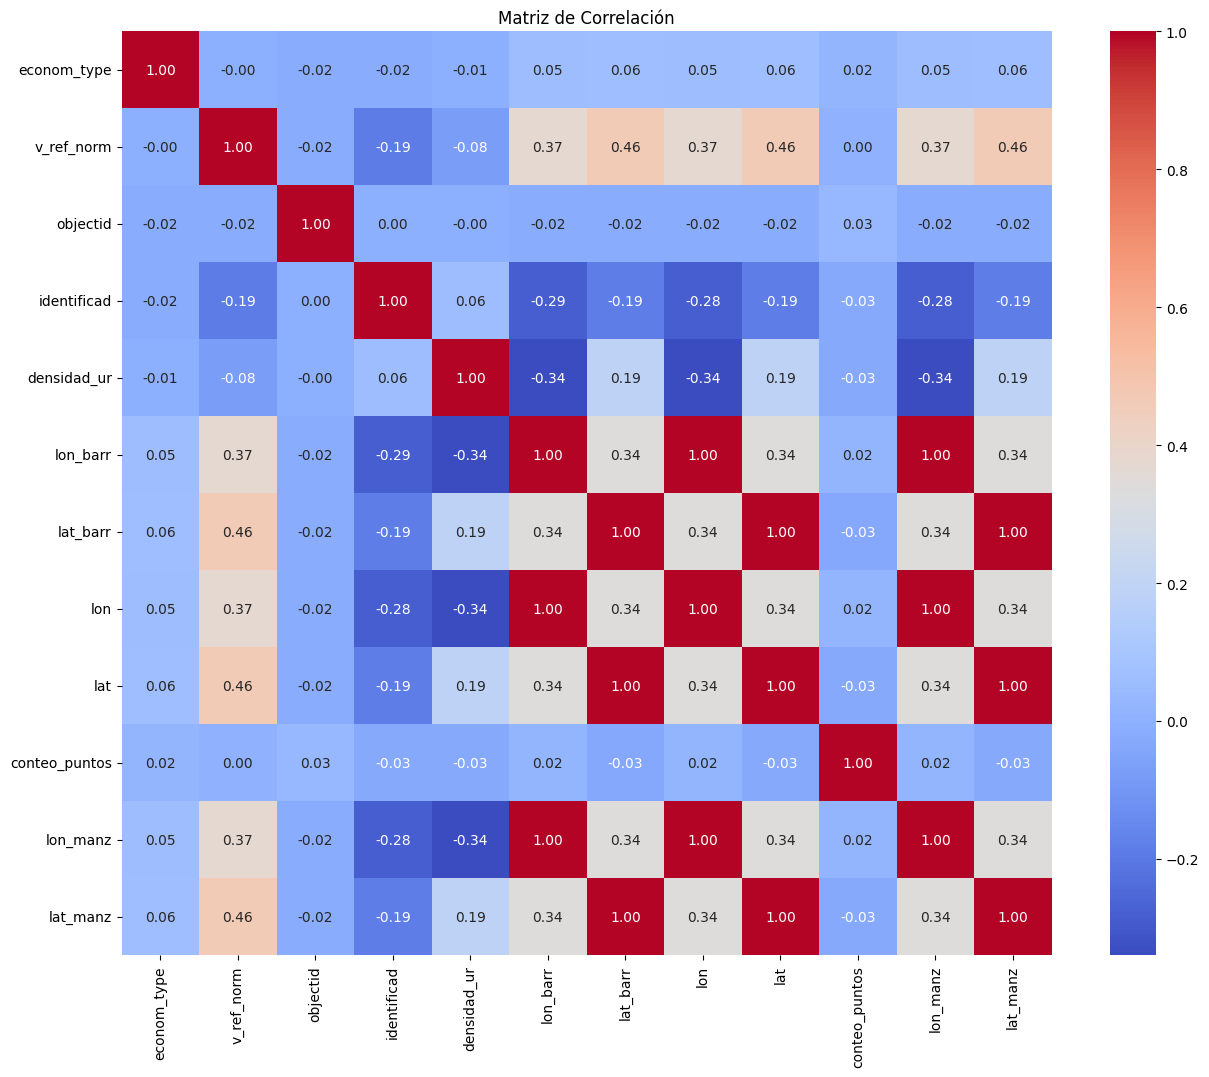

In [412]:
correlation_matrix = localidad_barrio_manzana_poi.corr(numeric_only=True)
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

In [413]:
numerical_feats = localidad_barrio_manzana_poi.dtypes[localidad_barrio_manzana_poi.dtypes != "object"].index
corr_abs = correlation_matrix.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, 'v_ref_norm')['v_ref_norm']
print(ser_corr)

v_ref_norm       1.000000
lat_barr         0.463713
lat              0.462855
lat_manz         0.462855
lon_barr         0.373233
lon_manz         0.372967
lon              0.372967
identificad      0.189499
densidad_ur      0.077593
objectid         0.017051
econom_type      0.002868
conteo_puntos    0.002521
Name: v_ref_norm, dtype: float64


In [414]:
label_encoder = LabelEncoder()
localidad_barrio_manzana_poi['barrio_name_normalized_encoded'] = label_encoder.fit_transform(localidad_barrio_manzana_poi['name_normalized'])
category_mapping = {category: index for index, category in enumerate(label_encoder.classes_)}
#print("Categorías y su número asignado:", category_mapping)

In [415]:
X = localidad_barrio_manzana_poi.drop(columns=['geometry', 'v_ref_norm', 'name_normalized', 'nombre_de_l','lon', 'lat', 'objectid', 'barrio_name', 
        'lon_manz','lat_manz',])
y = localidad_barrio_manzana_poi['v_ref_norm']
print(X.columns)

Index(['econom_type', 'identificad', 'densidad_ur', 'lon_barr', 'lat_barr',
       'conteo_puntos', 'barrio_name_normalized_encoded'],
      dtype='object')


In [416]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [417]:
X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [418]:
sc = StandardScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train))
X_test_sc = pd.DataFrame(sc.transform(X_test))

In [419]:

folds  = 5
score_calc = 'neg_mean_squared_error'



param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],
                 'random_state': [5] }

grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = folds, refit = True, verbose = 0, scoring = score_calc)
grid_dtree.fit(X_train, Y_train)

sc_dtree = get_best_score(grid_dtree)

pred_dtree = grid_dtree.predict(X_test)

0.5361187375451844
{'max_depth': 10, 'max_features': 11, 'max_leaf_nodes': None, 'min_samples_split': 30, 'random_state': 5}
DecisionTreeRegressor(max_depth=10, max_features=11, min_samples_split=30,
                      random_state=5)


In [420]:
r2_dtree = r2_score(y_test, pred_dtree)

In [421]:

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [60,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_rf.fit(X_train, Y_train)

sc_rf = get_best_score(grid_rf)
pred_rf = grid_rf.predict(X_test)

0.4426737999823297
{'min_samples_split': 10, 'n_estimators': 100, 'random_state': 5}
RandomForestRegressor(min_samples_split=10, random_state=5)


In [422]:
r2_rf = r2_score(y_test, pred_rf)

In [423]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]  }
grid_sgd = GridSearchCV(sgd, parameters, cv = folds, verbose = 0, scoring = score_calc)
grid_sgd.fit(X_train_sc, Y_train)

sc_sgd = get_best_score(grid_sgd)
pred_sgd = grid_sgd.predict(X_test_sc)

0.9846256098269036
{'alpha': 1e-05, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 10000}
SGDRegressor(alpha=1e-05, epsilon=0.01, max_iter=10000)


In [424]:
# Rsquared Score for SGDRegressor
r2_sgd = r2_score(y_test, pred_sgd)

In [425]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,              
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_knn.fit(X_train_sc, Y_train)
sc_knn = get_best_score(grid_knn)
pred_knn = grid_knn.predict(X_test_sc)

0.5079815092734262
{'algorithm': 'ball_tree', 'n_neighbors': 15, 'weights': 'distance'}
KNeighborsRegressor(algorithm='ball_tree', n_neighbors=15, weights='distance')


In [426]:
# Rsquared Score for KNN
r2_knn = r2_score(y_test, pred_knn)

/tmp/ipykernel_16583/3829537666.py:6: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x=list_regressors, y=list_scores, ax=ax, palette=palette, hue=list_regressors)


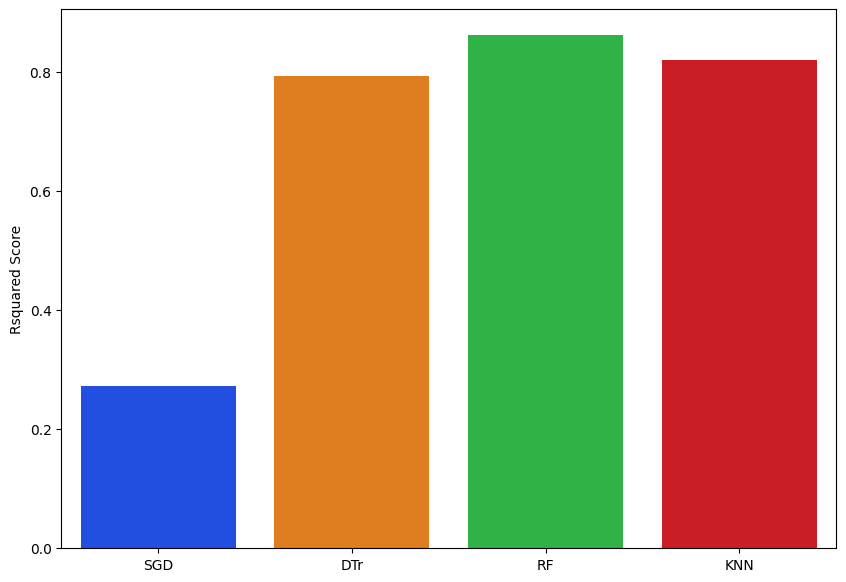

In [431]:
list_scores = [ r2_sgd, r2_dtree, r2_rf, r2_knn]
list_regressors = ['SGD','DTr','RF','KNN']
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
palette = sns.color_palette("bright")
sns.barplot(x=list_regressors, y=list_scores, ax=ax, palette=palette, hue=list_regressors)
plt.ylabel('Rsquared Score')
plt.show()